**Topic:** Challenge Set 7  
**Subject:** Classification  
**Date:** 02/04/2018  
**Name:** Arina Igumenshcheva  
**Worked with:** N/A


**Topic:  Classification**

**Settings:  Where applicable, use test_size=.30, random_state=4444.  This will permit comparison of results across users.

**Data:**

Challenges 1-10:  congressional votes [Congressional Voting Records Dataset](https://archive.ics.uci.edu/ml/datasets/Congressional+Voting+Records)

Challenge 11:     movie data

Challenge 12:     breast cancer surgery [Haberman Survival Dataset](https://archive.ics.uci.edu/ml/datasets/Haberman%27s+Survival)


**Data – Congressional Votes**

Download the congressional votes data from here:[Congressional Voting Records Dataset](https://archive.ics.uci.edu/ml/datasets/Congressional+Voting+Records)

These are votes of U.S. House of Representatives Congressmen on 16 key issues in 1984.

Read the description of the fields and download the data: house-votes-84.data

We will try to see if we can predict the house members' party based on their votes.

We will also use some of the general machine learning tools we learned (a bit more efficiently this time).

In [287]:
# Import python libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline


import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeCV
from sklearn import metrics
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold


**Challenge 1**

Load the data into a pandas dataframe. Replace 'y's with 1s, 'n's with 0s.

Now, almost every representative has a ?. This represents the absence of a vote (they were absent or some other similar reason). If we dropped all the rows that had a ?, we would throw out most of our data. Instead, we will replace ? with the best guess in the Bayesian sense: in the absence of any other information, we will say that the probability of the representative saying YES is the ratio of others that said YES over the whole votes.

So, convert each ? to this probability (when yes=1 and no=0, this is the mean of the column)


In [2]:
filepath = 'https://archive.ics.uci.edu/ml/machine-learning-databases/voting-records/house-votes-84.data'

f = lambda x : 1 if x == 'y' else (0 if x =='n' else np.nan)

converter_dict = {'dem_or_rep' : str,
                  'handicapped_infants' : f, 'water_project_cost_sharing' : f, 
                  'adoption_of_the_budget_resolution' : f, 'physician_fee_freeze' : f, 
                  'el_salvador_aid' : f, 'religious_groups_in_schools' : f, 
                  'anti_satellite_test_ban' : f, 'aid_to_nicaraguan_contras' : f, 
                  'mx_missile' : f, 'immigration' : f, 
                  'synfuels_corporation_cutback' : f, 'education_spending' : f, 
                  'superfund_right_to_sue' : f, 'crime' : f, 
                  'duty_free_exports' : f, 'export_administration_act_south_africa' : f}

congress_votes_df = pd.read_csv(filepath,
        names = ['dem_or_rep', 'handicapped_infants', 'water_project_cost_sharing', 
                 'adoption_of_the_budget_resolution', 'physician_fee_freeze', 
                 'el_salvador_aid', 'religious_groups_in_schools', 'anti_satellite_test_ban', 
                 'aid_to_nicaraguan_contras', 'mx_missile', 'immigration', 'synfuels_corporation_cutback', 
                 'education_spending', 'superfund_right_to_sue', 'crime', 'duty_free_exports', 
                 'export_administration_act_south_africa'],
        converters = converter_dict)

In [3]:
congress_votes_df.head()

,dem_or_rep,handicapped_infants,water_project_cost_sharing,adoption_of_the_budget_resolution,physician_fee_freeze,el_salvador_aid,religious_groups_in_schools,anti_satellite_test_ban,aid_to_nicaraguan_contras,mx_missile,immigration,synfuels_corporation_cutback,education_spending,superfund_right_to_sue,crime,duty_free_exports,export_administration_act_south_africa
0,republican,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,NaN,1.0,1.0,1.0,0.0,1.0
1,republican,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,NaN
2,democrat,NaN,1.0,1.0,NaN,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
3,democrat,0.0,1.0,1.0,0.0,NaN,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
4,democrat,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,NaN,1.0,1.0,1.0,1.0


In [4]:
congress_votes_df = congress_votes_df.fillna(congress_votes_df.mean().to_dict())

In [5]:
congress_votes_df.head()

,dem_or_rep,handicapped_infants,water_project_cost_sharing,adoption_of_the_budget_resolution,physician_fee_freeze,el_salvador_aid,religious_groups_in_schools,anti_satellite_test_ban,aid_to_nicaraguan_contras,mx_missile,immigration,synfuels_corporation_cutback,education_spending,superfund_right_to_sue,crime,duty_free_exports,export_administration_act_south_africa
0,republican,0.00000,1.0,0.0,1.000000,1.000000,1.0,0.0,0.0,0.0,1.0,0.362319,1.000000,1.0,1.0,0.0,1.000000
1,republican,0.00000,1.0,0.0,1.000000,1.000000,1.0,0.0,0.0,0.0,0.0,0.000000,1.000000,1.0,1.0,0.0,0.812689
2,democrat,0.44208,1.0,1.0,0.417453,1.000000,1.0,0.0,0.0,0.0,0.0,1.000000,0.000000,1.0,1.0,0.0,0.000000
3,democrat,0.00000,1.0,1.0,0.000000,0.504762,1.0,0.0,0.0,0.0,0.0,1.000000,0.000000,1.0,0.0,0.0,1.000000
4,democrat,1.00000,1.0,1.0,0.000000,1.000000,1.0,0.0,0.0,0.0,0.0,1.000000,0.423267,1.0,1.0,1.0,1.000000


**Challenge 2**

Split the data into a test and training set. Use this function:

```
from sklearn.cross_validation import train_test_split
```

In [6]:
# Split the data into training and test sets
X = congress_votes_df.iloc[:, 1:].copy()
y = congress_votes_df.iloc[:, 0].copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [7]:
X_train.head()

,handicapped_infants,water_project_cost_sharing,adoption_of_the_budget_resolution,physician_fee_freeze,el_salvador_aid,religious_groups_in_schools,anti_satellite_test_ban,aid_to_nicaraguan_contras,mx_missile,immigration,synfuels_corporation_cutback,education_spending,superfund_right_to_sue,crime,duty_free_exports,export_administration_act_south_africa
339,1.0,0.0,0.0,1.0,1.0,1.0,0.000000,0.00000,0.000000,0.000000,1.0,1.0,1.0,1.0,0.0,0.000000
388,0.0,1.0,1.0,1.0,1.0,1.0,0.000000,0.00000,0.000000,0.000000,0.0,1.0,1.0,1.0,0.0,0.812689
357,0.0,0.0,0.0,1.0,1.0,1.0,0.000000,0.00000,0.000000,0.000000,0.0,1.0,1.0,1.0,0.0,0.000000
307,1.0,0.0,1.0,0.0,0.0,1.0,1.000000,1.00000,1.000000,0.000000,0.0,0.0,0.0,1.0,0.0,0.812689
433,0.0,0.0,0.0,1.0,1.0,1.0,0.567696,0.57619,0.501211,0.504673,0.0,1.0,1.0,1.0,0.0,1.000000




**Challenge 3**

Using scikit.learn's KNN algorithm, train a model that predicts the party (republican/democrat):

```
from sklearn.neighbors import KNeighborsClassifier
```

Try it with a lot of different k values (number of neighbors), from 1 to 20, and on the test set calculate the accuracy (number of correct predictions / number of all predictions) for each k

You can use this to calculate accuracy:

```
from sklearn.metrics import accuracy_score
```

Which k value gives the highest accuracy?

In [8]:
from sklearn.neighbors import KNeighborsClassifier

In [48]:
k_accuracies = []

for k in range(1, 21):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_test_pred = knn.predict(X_test)

    k_accuracies.append(metrics.accuracy_score(y_test, y_test_pred))

In [49]:
len(k_accuracies)

20

In [295]:
max_k_accuracy = max(k_accuracies)
k_max = k_accuracies.index(max_k_accuracy) + 1
print("k = " + str(k_max) + " gives the highest accuracy score, which is " +str(max_k_accuracy))

k = 5 gives the highest accuracy score, which is 0.961832061069



**Challenge 4**

Make a similar model but with `LogisticRegression` instead, calculate test accuracy.

In [296]:
logreg = LogisticRegression()

logreg.fit(X_train, y_train)
y_test_pred_logistic = logreg.predict(X_test)

accuracy_logistic = metrics.accuracy_score(y_test, y_test_pred_logistic)
accuracy_logistic

0.97709923664122134



**Challenge 5**

Make a bar graph of democrats and republicans. How many of each are there?

Make a very simple predictor that predicts 'democrat' for every incoming example.

Just make a function that takes in an X --an array or matrix with input examples--, and returns an array of the same length as X, where each value is 'democrat'. For example, if X is three rows, your function should return ['democrat','democrat','democrat']. Make a y_predicted vector using this and measure its accuracy.

Do the same with predicting 'republican' all the time and measure its accuracy.

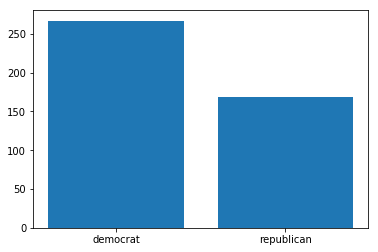

In [297]:
plt.bar(['democrat', 'republican'],[len(y[y == 'democrat']),len(y[y == 'republican'])]);

In [298]:
y.value_counts()

democrat      267
republican    168
Name: dem_or_rep, dtype: int64

In [299]:
def always_dem(X):
    return np.repeat('democrat',len(X))

def always_rep(X):
    return np.repeat('republican',len(X))

In [300]:
# Always-democrat model accuracy
y_predicted = always_dem(X_test)
accuracy_always_dem = metrics.accuracy_score(y_test, y_predicted)
accuracy_always_dem

0.59541984732824427

In [301]:
# Always-republican model accuracy
y_predicted = always_rep(X_test)
accuracy_always_rep = metrics.accuracy_score(y_test, y_predicted)
accuracy_always_rep

0.40458015267175573


**Challenge 6**

Plot the accuracies as a function of k. Since k only matters for KNN, your logistic regression accuracy, 'democrat' predictor accuracy and 'republican' predictor accuracy will stay the same over all k, so each of these three will be a horizontal line. But the KNN accuracy will change with k.


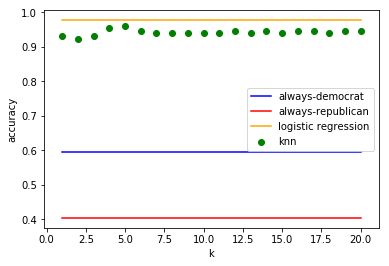

In [302]:
fig,ax = plt.subplots(1,1)
ax.plot(list(range(1,21)), np.repeat(accuracy_always_dem, 20), label='always-democrat', color='blue')
ax.plot(list(range(1,21)), np.repeat(accuracy_always_rep, 20), label='always-republican', color='red')
ax.plot(list(range(1,21)), np.repeat(accuracy_logistic, 20), label='logistic regression', color='orange')
ax.scatter(list(range(1,21)), k_accuracies, label='knn', c='g')
ax.set_ylabel('accuracy')
ax.set_xlabel('k')
ax.legend();



**Challenge 7**

Plot a learning curve for the logistic regression model. But instead of going through the painstaking steps of doing it yourself, use this function:

```
from sklearn.learning_curve import learning_curve
```

This will give you the m, training errors and testing errors. All you need to do is plot them. You don't even need to give it separate training/test sets. It will do crossvalidation all by itself. Easy, isn't it? : )
Remember, since it does cross-validation, it doesn't have a single training error or test error per m value. Instead, it has one for each fold (separate partition) of the cross validation. A good idea is to take the mean of these errors from different folds. This gives you a meaningful single number per m. What I mean is that doing something like:

```
train_cv_err = np.mean(train_err, axis=1)
test_cv_err = np.mean(ts_err, axis=1)
```

Before plotting `m` vs `train_cv_err` and `m` vs `test_cv_err`, where `train_err` and `test_err` are the vectors returned by the learning curve function. The `np.mean(...., axis=1)` means take the mean along axis 1 (axis 1 is the columns axis-- for each row, you have a bunch of columns, each corresponding to a cross validation fold, you are averaging these columns for each row).

Draw the learning curve for KNN with the best k value as well.



In [303]:
from sklearn.model_selection import learning_curve

In [218]:
#train_sizes, train_scores, valid_scores = learning_curve(
#    LogisticRegression(), X, y, train_sizes =np.linspace(0.1, 1.0, 10), cv=5 )

In [304]:
train_sizes, train_scores, valid_scores = learning_curve(
    LogisticRegression(), X, y, train_sizes =list(range(5,len(X)-5,5)), cv =len(X)//5)

In [305]:
train_sizes

array([  5,  10,  15,  20,  25,  30,  35,  40,  45,  50,  55,  60,  65,
        70,  75,  80,  85,  90,  95, 100, 105, 110, 115, 120, 125, 130,
       135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195,
       200, 205, 210, 215, 220, 225, 230, 235, 240, 245, 250, 255, 260,
       265, 270, 275, 280, 285, 290, 295, 300, 305, 310, 315, 320, 325,
       330, 335, 340, 345, 350, 355, 360, 365, 370, 375, 380, 385, 390,
       395, 400, 405, 410, 415, 420, 425])

In [306]:
train_scores

array([[ 0.8       ,  1.        ,  1.        , ...,  1.        ,
         1.        ,  1.        ],
       [ 0.9       ,  1.        ,  1.        , ...,  1.        ,
         1.        ,  1.        ],
       [ 0.93333333,  1.        ,  0.93333333, ...,  0.93333333,
         0.93333333,  0.93333333],
       ..., 
       [ 0.97108434,  0.97349398,  0.97108434, ...,  0.97108434,
         0.97108434,  0.97108434],
       [ 0.97142857,  0.97380952,  0.97142857, ...,  0.97142857,
         0.97142857,  0.97142857],
       [ 0.97176471,  0.97411765,  0.97176471, ...,  0.97176471,
         0.97176471,  0.97176471]])

In [307]:
train_cv_err = np.mean(train_scores, axis=1)

In [308]:
test_cv_err = np.mean(valid_scores, axis=1)

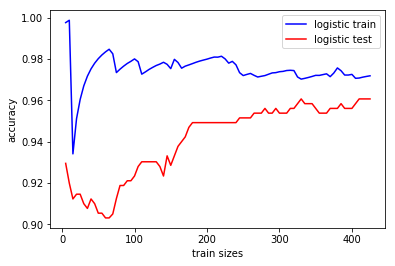

In [309]:
fig,ax = plt.subplots(1,1)
ax.plot(train_sizes, train_cv_err, label='logistic train', color='blue')
ax.plot(train_sizes, test_cv_err, label='logistic test', color='red')
ax.set_ylabel('accuracy')
ax.set_xlabel('train sizes')
ax.legend();

In [311]:
# Learning curve for KNN with best k
train_sizes, train_scores, valid_scores = learning_curve(
    KNeighborsClassifier(n_neighbors=5), X, y, train_sizes =list(range(5,len(X)-5,5)), cv =len(X)//5)

In [312]:
train_cv_err = np.mean(train_scores, axis=1)
test_cv_err = np.mean(valid_scores, axis=1)

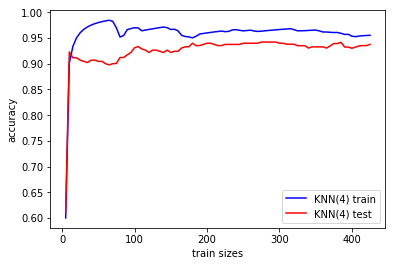

In [313]:
fig,ax = plt.subplots(1,1)
ax.plot(train_sizes, train_cv_err, label='KNN(4) train', color='blue')
ax.plot(train_sizes, test_cv_err, label='KNN(4) test', color='red')
ax.set_ylabel('accuracy')
ax.set_xlabel('train sizes')
ax.legend();

**Challenge 8**

This is a preview of many other classification algorithms that we will go over. Scikit.learn has the same interface for all of these, so you can use them exactly the same way as you did LogisticRegression and KNeighborsClassifier. Use each of these to classify your data and print the test accuracy of each:

Gaussian Naive Bayes

```
from sklearn.naive_bayes import GaussianNB
```

SVM (Support Vector Machine) Classifier

```
from sklearn.svm import SVC
```

Decision Tree

```
from sklearn.tree import DecisionTreeClassifier
```

Random Forest

```
from sklearn.ensemble import RandomForestClassifier
```


In [314]:
# Gaussian Naive Bayes
from sklearn.naive_bayes import GaussianNB

In [318]:
gaussian = GaussianNB()
gaussian.fit(X_train, y_train)
y_test_pred_gaussian = gaussian.predict(X_test)
accuracy_gaussian = metrics.accuracy_score(y_test, y_test_pred_gaussian)
accuracy_gaussian

0.94656488549618323

In [315]:
# SVM (Support Vector Machine) Classifier
from sklearn.svm import SVC

In [319]:
svcm = SVC()
svcm.fit(X_train, y_train)
y_test_pred_svcm = svcm.predict(X_test)
accuracy_svcm = metrics.accuracy_score(y_test, y_test_pred_svcm)
accuracy_svcm

0.97709923664122134

In [316]:
# Decision Tree
from sklearn.tree import DecisionTreeClassifier

In [320]:
dec_trees = DecisionTreeClassifier()
dec_trees.fit(X_train, y_train)
y_test_pred_dec_trees = dec_trees.predict(X_test)
accuracy_dec_trees = metrics.accuracy_score(y_test, y_test_pred_dec_trees)
accuracy_dec_trees

0.93129770992366412

In [317]:
#Random Forest
from sklearn.ensemble import RandomForestClassifier

In [321]:
rand_forest = RandomForestClassifier()
rand_forest.fit(X_train, y_train)
y_test_pred_rand_forest = rand_forest.predict(X_test)
accuracy_rand_forest = metrics.accuracy_score(y_test, y_test_pred_rand_forest)
accuracy_rand_forest

0.96183206106870234



**Challenge 9**

There is actually a way to do cross validation quickly to get your accuracy results for an algorithm, without separating training and test yourself:

```
from sklearn.cross_validation import cross_val_score
```

Just like the `learning_curve` function, this takes a classifier object, `X` and `Y`. Returns accuracy (or whatever score you prefer by using the _scoring_ keyword argument). Of course, it will return a score for each cross validation fold, so to get the generalized accuracy, you need to take the mean of what it returns.

Use this function to calculate the cross validation score of each of the classifiers you tried before.



In [322]:
from sklearn.cross_validation import cross_val_score

In [326]:
# Cross-validation score for KNeighborsClassifier with k=5 
np.mean(cross_val_score(KNeighborsClassifier(n_neighbors=5), X, y))

0.93333333333333324

In [327]:
# Cross-validation score for LogisticRegression 
np.mean(cross_val_score(LogisticRegression(), X, y))

0.96091954022988502

In [328]:
# Cross-validation score for Gaussian Naive Bayes 
np.mean(cross_val_score(GaussianNB(), X, y))

0.93103448275862066

In [329]:
# Cross-validation score for Support Vector Machine classifier 
np.mean(cross_val_score(SVC(), X, y))

0.95402298850574718

In [330]:
# Cross-validation score for DecisionTreeClassifier 
np.mean(cross_val_score(DecisionTreeClassifier(), X, y))

0.95632183908045976

In [331]:
# Cross-validation score for RandomForestClassifier 
np.mean(cross_val_score(RandomForestClassifier(), X, y))

0.96091954022988502


**Challenge 10**

Instead of 'democrat' or 'republican', can you predict the vote of a representative based on their other votes?

Reload the data from scratch. Convert y-->1, n-->0.

Choose one vote. Build a classifier (logistic regression or KNN), that uses the other votes (do not use the party as a feature) to predict if the vote will be 1 or 0.

Convert each ? to the mode of the column (if a senator has not voted, make their vote 1 if most others voted 1, make it 0 if most others voted 0).

Calculate the cross validation accuracy of your classifier for predicting how each representative will vote on the issue.



In [339]:
f = lambda x : 1 if x == 'y' else (0 if x =='n' else np.nan)

converter_dict = {'dem_or_rep' : str,
                  'handicapped_infants' : f, 'water_project_cost_sharing' : f, 
                  'adoption_of_the_budget_resolution' : f, 'physician_fee_freeze' : f, 
                  'el_salvador_aid' : f, 'religious_groups_in_schools' : f, 
                  'anti_satellite_test_ban' : f, 'aid_to_nicaraguan_contras' : f, 
                  'mx_missile' : f, 'immigration' : f, 
                  'synfuels_corporation_cutback' : f, 'education_spending' : f, 
                  'superfund_right_to_sue' : f, 'crime' : f, 
                  'duty_free_exports' : f, 'export_administration_act_south_africa' : f}

congress_votes_df = pd.read_csv(filepath,
        names = ['dem_or_rep', 'handicapped_infants', 'water_project_cost_sharing', 
                 'adoption_of_the_budget_resolution', 'physician_fee_freeze', 
                 'el_salvador_aid', 'religious_groups_in_schools', 'anti_satellite_test_ban', 
                 'aid_to_nicaraguan_contras', 'mx_missile', 'immigration', 'synfuels_corporation_cutback', 
                 'education_spending', 'superfund_right_to_sue', 'crime', 'duty_free_exports', 
                 'export_administration_act_south_africa'],
        converters = converter_dict)

In [340]:
congress_votes_df.head()

,dem_or_rep,handicapped_infants,water_project_cost_sharing,adoption_of_the_budget_resolution,physician_fee_freeze,el_salvador_aid,religious_groups_in_schools,anti_satellite_test_ban,aid_to_nicaraguan_contras,mx_missile,immigration,synfuels_corporation_cutback,education_spending,superfund_right_to_sue,crime,duty_free_exports,export_administration_act_south_africa
0,republican,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,NaN,1.0,1.0,1.0,0.0,1.0
1,republican,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,NaN
2,democrat,NaN,1.0,1.0,NaN,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
3,democrat,0.0,1.0,1.0,0.0,NaN,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
4,democrat,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,NaN,1.0,1.0,1.0,1.0


In [354]:
congress_votes_df = congress_votes_df.fillna(congress_votes_df.mode().loc[0])

In [356]:
congress_votes_df.mode()

,dem_or_rep,handicapped_infants,water_project_cost_sharing,adoption_of_the_budget_resolution,physician_fee_freeze,el_salvador_aid,religious_groups_in_schools,anti_satellite_test_ban,aid_to_nicaraguan_contras,mx_missile,immigration,synfuels_corporation_cutback,education_spending,superfund_right_to_sue,crime,duty_free_exports,export_administration_act_south_africa
0,democrat,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0


In [355]:
congress_votes_df.head()

,dem_or_rep,handicapped_infants,water_project_cost_sharing,adoption_of_the_budget_resolution,physician_fee_freeze,el_salvador_aid,religious_groups_in_schools,anti_satellite_test_ban,aid_to_nicaraguan_contras,mx_missile,immigration,synfuels_corporation_cutback,education_spending,superfund_right_to_sue,crime,duty_free_exports,export_administration_act_south_africa
0,republican,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0
1,republican,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0
2,democrat,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
3,democrat,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
4,democrat,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0


In [360]:
# Predict immigration vote based on other votes, using KNN with k=5
X = congress_votes_df.iloc[:, 1:].copy()
X.drop('immigration', axis=1, inplace=True)
y = congress_votes_df['immigration'].copy()

In [361]:
X.head()

,handicapped_infants,water_project_cost_sharing,adoption_of_the_budget_resolution,physician_fee_freeze,el_salvador_aid,religious_groups_in_schools,anti_satellite_test_ban,aid_to_nicaraguan_contras,mx_missile,synfuels_corporation_cutback,education_spending,superfund_right_to_sue,crime,duty_free_exports,export_administration_act_south_africa
0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0
1,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0
2,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
3,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
4,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0


In [362]:
y[:5]

0    1.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: immigration, dtype: float64

In [366]:
# KNN model
knn5 = KNeighborsClassifier(n_neighbors=5)

# Cross-validation accuracy
np.mean(cross_val_score(knn5, X, y))

0.52865777917738244


**Challenge 11**

Back to movie data! Choose one categoric feature to predict. I chose MPAA Rating, but genre, month, etc. are all decent choices. If you don't have any non-numeric features, you can make two bins out of a numeric one (like "Runtime>100 mins" and "Runtime<=100 mins")

Make a bar graph of how many of each movie there is in the data. For example, with Ratings, show how many G, PG, PG-13, R movies there are, etc. (basically a histogram of your labels).

Predict your outcome variable (labels) using KNN and logistic regression. Calculate their accuracies.

Make a baseline stupid predictor that always predicts the label that is present the most in the data. Calculate its accuracy on a test set.

How much better do KNN and logistic regression do versus the baseline?

What are the coefficients of logistic regression? Which features affect the outcome how?


In [411]:
# Import the movies data
filepath = 'https://raw.githubusercontent.com/33eyes/nyc18_ds14/master/challenges/challenges_data/2013_movies.csv?token=ANE-v-MauItGvS7Y5l5d8R09FhJo3z-Bks5aeZN3wA%3D%3D'
movies_df = pd.read_csv(filepath)

movies_df.head()

,Title,Budget,DomesticTotalGross,Director,Rating,Runtime,ReleaseDate
0,The Hunger Games: Catching Fire,130000000.0,424668047,Francis Lawrence,PG-13,146,2013-11-22 00:00:00
1,Iron Man 3,200000000.0,409013994,Shane Black,PG-13,129,2013-05-03 00:00:00
2,Frozen,150000000.0,400738009,Chris BuckJennifer Lee,PG,108,2013-11-22 00:00:00
3,Despicable Me 2,76000000.0,368061265,Pierre CoffinChris Renaud,PG,98,2013-07-03 00:00:00
4,Man of Steel,225000000.0,291045518,Zack Snyder,PG-13,143,2013-06-14 00:00:00


In [412]:
list(movies_df['Rating'].value_counts().values)

[47, 37, 15, 1]

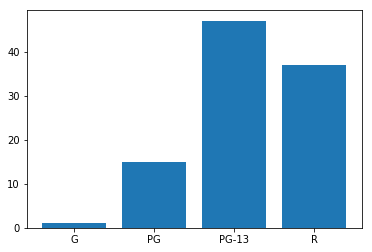

In [413]:
plt.bar(list(movies_df['Rating'].value_counts().index),
        list(movies_df['Rating'].value_counts().values));

In [414]:
movies_df2 = movies_df[movies_df['Rating'] != 'G'].copy()
X = movies_df2.copy()
X.drop(['Rating', 'ReleaseDate', 'Director', 'Title'], axis=1, inplace=True)
y = movies_df2['Rating'].copy()

In [415]:
X = X.fillna(X.mean().to_dict())

In [444]:
# KNN
knn5 = KNeighborsClassifier(n_neighbors=40)

# Cross-validation accuracy
np.mean(cross_val_score(knn5, X, y))

0.50441919191919193

In [417]:
# Logistic regression
logreg = LogisticRegression()

# Cross-validation accuracy
np.mean(cross_val_score(logreg, X, y))

0.53384952465834823

In [418]:
def always_pg13(X):
    return np.repeat('PG-13',len(X))

In [420]:
# Always-PG13 model accuracy
y_predicted = always_pg13(X)
accuracy_always_pg13 = metrics.accuracy_score(y, y_predicted)
accuracy_always_pg13

0.47474747474747475

KNN and logistic regression are doing slightly better than the always-PG-13 predictor, and all 3 have about 0.5 accuracy.

In [447]:
# Coefficients of the logistic regression
logreg.fit(X,y).coef_

array([[ -1.00727958e-08,  -3.64473346e-09,  -1.71660318e-13],
       [  7.12182712e-09,  -3.24848147e-09,  -3.60270248e-14],
       [ -1.40579712e-08,   1.29551776e-09,   7.71187164e-14]])

In [448]:
logreg.fit(X,y).intercept_

array([ -1.41744233e-15,  -4.51695240e-16,   6.79307943e-16])



**Challenge 12**

Now you are a classification master. The representative votes dataset only had 0s and 1s. Let's just swiftly tackle the breast cancer surgery data.

Get it from here: [Haberman Survival Dataset](https://archive.ics.uci.edu/ml/datasets/Haberman%27s+Survival)

 * What is the average and standard deviation of the age of all of the patients?
 * What is the average and standard deviation of the age of those patients that survived 5 or more years after surgery?
 * What is the average and standard deviation of the age of those patients who survived fewer than 5 years after surgery?
 * Plot a histogram of the ages side by side with a histogram of the number of axillary nodes.
 * What is the earliest year of surgery in this dataset?
 * What is the most recent year of surgery?
 * Use logistic regression to predict survival after 5 years. How well does your model do?
 * What are the coefficients of logistic regression? Which features affect the outcome how?
 * Draw the learning curve for logistic regression in this case.